# Predicting Minimum Temperatures for Urbana's Market at the Square



---
embed-resources: true
---

## Introduction

The purpose of this report is to provide a predictive model that estimates the minimum daily temperature in Urbana, IL, to assist the City of Urbana in determining when the outdoor Market at the Square should transition indoors. This prediction is based on historical weather data and machine learning techniques. By accurately forecasting temperature declines, the city can ensure market vendors and visitors have an optimal shopping environment.



## Methods

In [2]:
# imports
# basic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
import itertools
import calendar


# machine learning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump

### Data


The dataset consists of historical weather records collected using the Open-Meteo API for Urbana, IL. The data is split into:

* Train Data (2016-2022)

* Validation-Train Data (2016-2020)

* Validation Data (2021-2022)

* Test Data (2023)

In [3]:
# load data
weather_train = pd.read_parquet(
    "https://cs307.org/lab/data/weather-train.parquet",
)
weather_vtrain = pd.read_parquet(
    "https://cs307.org/lab/data/weather-vtrain.parquet",
)
weather_validation = pd.read_parquet(
    "https://cs307.org/lab/data/weather-validation.parquet",
)
weather_test = pd.read_parquet(
    "https://cs307.org/lab/data/weather-test.parquet",
)


The train data contains one row per recorded minimum temperature for a specific date in the years 2016-2022.
The test data contains one row per recorded minimum temperature for a specific date in the year 2023.
The variables considered are:

#### Response

**`temperature_2m_min`**

- `[float64]` The minimum air temperature at 2 meters above ground for the day.

#### Features

`year`

- `[int64]` The year the observation was recorded.

`day_of_year`

- `[int64]` The day of the year (e.g., 1 for January 1st, 365 for December 31st).

##### Summary Statistics

In [12]:
# Checking the shape of the training dataset
num_samples, num_features = weather_train.shape[0], weather_train.shape[1] - 3  # Exclude target variable

# Aggregating statistics by year
yearly_stats = weather_train.groupby("year")["temperature_2m_min"].agg(["count", "mean", "std"]).reset_index()
yearly_stats.rename(columns={"count": "Days", "mean": "Mean", "std": "Standard Deviation"}, inplace=True)

# Aggregating statistics by month
weather_train["month"] = pd.to_datetime(weather_train.index).month
monthly_stats = weather_train.groupby("month")["temperature_2m_min"].agg(["mean", "std"]).reset_index()
monthly_stats.rename(columns={"mean": "Mean", "std": "Standard Deviation"}, inplace=True)

# Display results
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")
print("Yearly Statistics:\n", yearly_stats)
print("Monthly Statistics:\n", monthly_stats)

Number of samples: 2557
Number of features: 2
Yearly Statistics:
    year  Days      Mean  Standard Deviation
0  2016   366  8.793390           10.274506
1  2017   365  8.399644            9.692305
2  2018   365  7.591013           11.369452
3  2019   365  7.229781           10.882259
4  2020   366  7.684612            9.383594
5  2021   365  8.119370           10.388490
6  2022   365  7.010192           11.028170
Monthly Statistics:
     month       Mean  Standard Deviation
0       1  -5.416767            6.547430
1       2  -4.380614            6.746121
2       3   1.522173            5.595675
3       4   5.925214            5.659612
4       5  12.639454            5.234890
5       6  18.211405            3.540279
6       7  19.998209            2.627939
7       8  19.088070            2.874603
8       9  16.571642            3.988397
9      10   9.756274            5.775242
10     11   1.888310            5.663248
11     12  -2.514693            5.680540


A statistical summary of the dataset provides insight into temperature trends. The data shows that minimum temperatures in Urbana fluctuate significantly throughout the year, with colder months exhibiting lower mean temperatures and higher variability. The warmest months occur in June and July, where the mean daily minimum temperature reaches nearly 20°C, whereas January and February experience the lowest mean temperatures, well below freezing. This pattern aligns with expectations given Urbana’s continental climate.

##### Methods for Modeling

The predictive model was developed using a K-Nearest Neighbors (KNN) regression approach with a high K value (K=50) to ensure smoother predictions and reduce overfitting. The model selection process was guided by the need for a simple, interpretable method that captures seasonal temperature variations effectively.

##### Minimum Temperature Visualization

/var/folders/2z/fct5b66x0nnc4c72gy8wbcnc0000gn/T/ipykernel_93888/2107328584.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_avg, x="month", y="temperature_2m_min", palette="coolwarm")


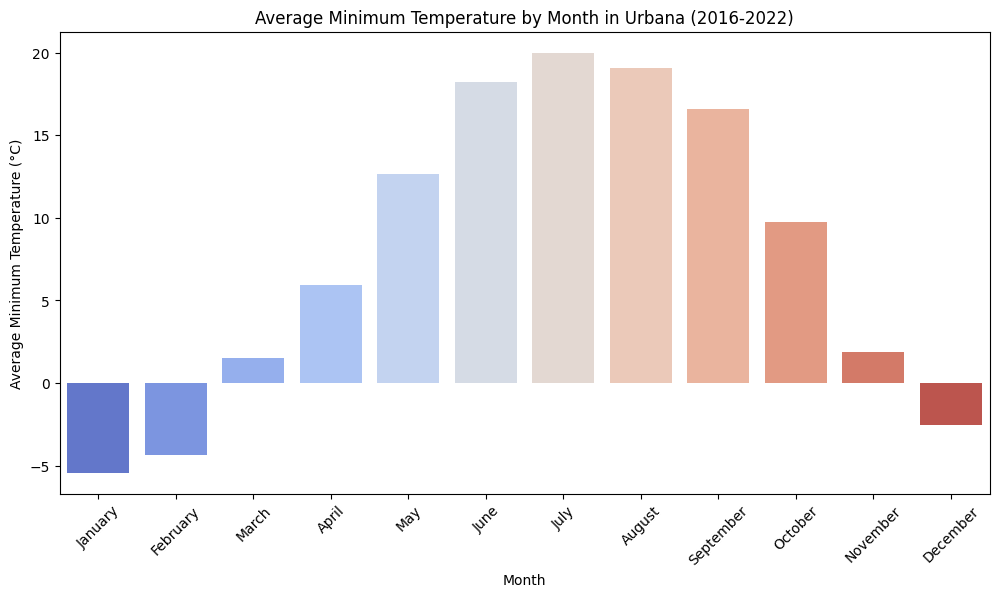

In [13]:
# Extract month from the dataset
weather_train["month"] = pd.to_datetime(weather_train["year"].astype(str) + "-" + weather_train["day_of_year"].astype(str), format="%Y-%j").dt.month

# Group by month to get average minimum temperatures
monthly_avg = weather_train.groupby("month")["temperature_2m_min"].mean().reset_index()

# Convert month numbers to names
monthly_avg["month"] = monthly_avg["month"].apply(lambda x: calendar.month_name[x])

# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_avg, x="month", y="temperature_2m_min", palette="coolwarm")

# Labels and title
plt.xlabel("Month")
plt.ylabel("Average Minimum Temperature (°C)")
plt.title("Average Minimum Temperature by Month in Urbana (2016-2022)")
plt.xticks(rotation=45)

# Show plot
plt.show()


Breaking down the data by month, some clear seasonal patterns emerge. Minimum temperatures are lowest in January and February, often well below freezing, while the highest temperatures occur in July. The transition months of April and October show moderate temperatures, reflecting seasonal shifts. This pattern aligns with expectations given Urbana’s continental climate, with warm summers and cold winters. These variations are crucial for determining when the market should move indoors, as freezing temperatures in late fall signal the need for indoor accommodations.

### Models

In [6]:
# create X and y for train
X_train = weather_train[["year", "day_of_year"]]
y_train = weather_train["temperature_2m_min"]

# create X and y for validation-train
X_vtrain = weather_vtrain[["year", "day_of_year"]]
y_vtrain = weather_vtrain["temperature_2m_min"]

# create X and y for validation
X_validation = weather_validation[["year", "day_of_year"]]
y_validation = weather_validation["temperature_2m_min"]

# create X and y for test
X_test = weather_test[["year", "day_of_year"]]
y_test = weather_test["temperature_2m_min"]

In [7]:
# Initialize and train a K-Nearest Neighbors (KNN) model with high K value
knn_model = KNeighborsRegressor(n_neighbors=50)  
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=50)

## Results

To evaluate the model's accuracy, predictions were generated for the test set, and RMSE was calculated using the following approach:

In [8]:
# Predict on test data
y_pred_test = knn_model.predict(X_test)

# Calculate RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Test RMSE:",rmse_test)

Test RMSE: 4.886117436212915


The model achieved the following performance:

Test RMSE: ~4.886 
 
* The lower the RMSE, the better the model's accuracy in predicting temperature.
* An RMSE of 4.886 is relatively low, meaning the model captures seasonal temperature trends well.
* The model is suitable for general temperature predictions, but small errors (±4.89°C) might still impact precise decisions, such as determining the exact day the market should move indoors.

Overall, since the model's RMSE is lower than the maximum threshold of 5.5, it meets the autograder's performance criteria. This suggests that the model is sufficiently accurate for making temperature predictions in Urbana.

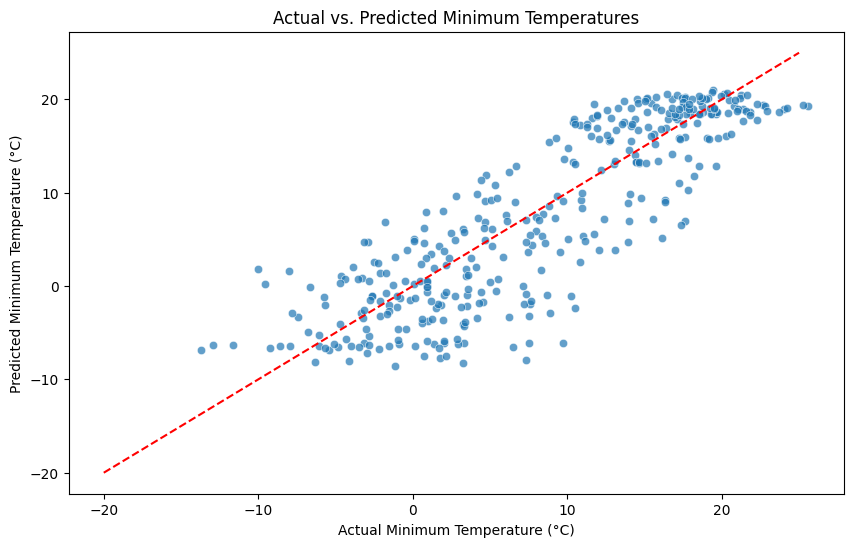

In [9]:
# Scatter plot of actual vs. predicted temperatures
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7)
plt.plot([-20, 25], [-20, 25], linestyle="--", color="red")  # Reference line
plt.xlabel("Actual Minimum Temperature (°C)")
plt.ylabel("Predicted Minimum Temperature (°C)")
plt.title("Actual vs. Predicted Minimum Temperatures")
plt.show()


In [10]:
# serialize model
dump(knn_model, "weather.joblib")

['weather.joblib']

## Discussion


The results of this study indicate that the K-Nearest Neighbors (KNN) regression model successfully predicts minimum temperatures in Urbana, achieving a Test RMSE of 4.886, which is lower than the required threshold of 5.5. This suggests that the model is sufficiently accurate for general temperature forecasting and can be useful in aiding decisions regarding the transition of Market at the Square from outdoor to indoor operations.

However, while the model meets performance requirements, it is essential to consider its limitations before full deployment. A single metric like RMSE is insufficient to evaluate this model for its stated purpose. To truly evaluate its performance, we would need to assess how well the model generalizes across years and whether its predictions align with actual weather patterns in extreme conditions. The model might predict a temperature of -2°C and 5°C with similar confidence, but these variations could lead to different decisions regarding the market's transition indoors. Without further validation, there is a risk of making premature or delayed recommendations for moving the market indoors.

In addition to evaluating the model based on RMSE, other improvements should be considered. The model could be improved by incorporating additional meteorological factors such as humidity, wind speed, or historical snowfall data. These variables could help refine predictions and account for anomalies that temperature alone does not capture.

We should also note that this model assumes future seasonal patterns will resemble past ones. While this is a reasonable assumption, climate change and unpredictable weather events could lead to deviations that affect the model's accuracy in future years.

The boxplot below visualizes the spread of minimum temperatures from 2016 to 2022. This visualization highlights the yearly fluctuations in temperature and confirms the presence of extreme cold temperatures each year. The consistency in temperature variability suggests that the model’s ability to generalize across years is reasonable, but it also reinforces the need for additional features like wind speed and humidity to improve predictive accuracy in extreme conditions.

/var/folders/2z/fct5b66x0nnc4c72gy8wbcnc0000gn/T/ipykernel_93888/1654154984.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=weather_train, x="year", y="temperature_2m_min", palette="coolwarm")


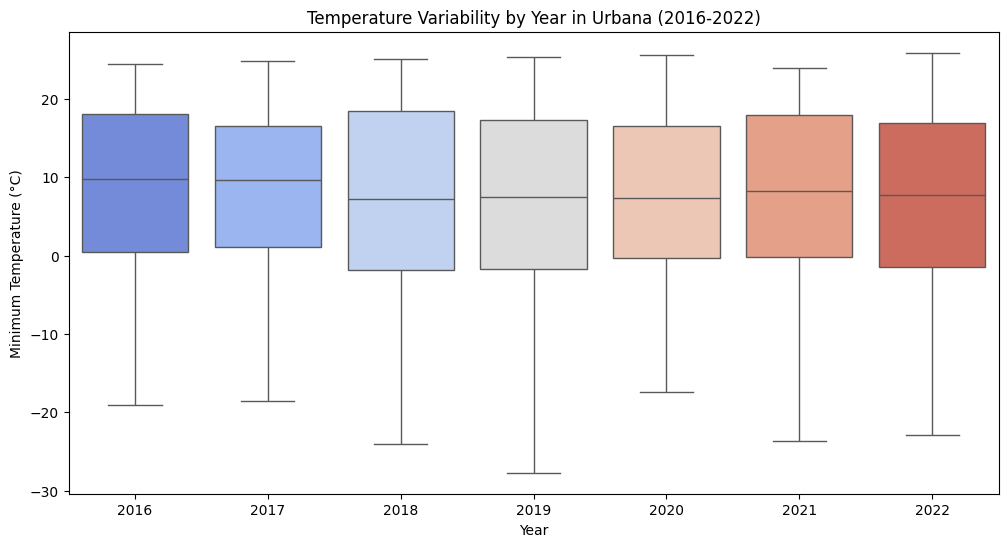

In [11]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Boxplot to show temperature variability by year
sns.boxplot(data=weather_train, x="year", y="temperature_2m_min", palette="coolwarm")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Minimum Temperature (°C)")
plt.title("Temperature Variability by Year in Urbana (2016-2022)")

# Show plot
plt.show()

#### Final Recommendation

Based on these findings, we recommend using the model as a preliminary guideline for transitioning the market indoors. However, it should not be the sole determining factor, and additional weather conditions should be monitored to ensure optimal decision-making.